as per https://arxiv.org/pdf/1910.06444.pdf (siamese like net but don't share weights)

##### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.vision import learner
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
image_crops_dir_post = data_dir / "classification_crops_post"
image_crops_dir_pre = data_dir / "classification_crops_pre"
models_path = data_dir / "models"

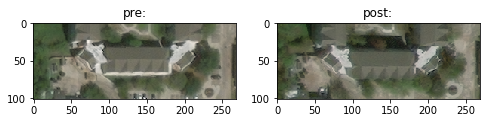

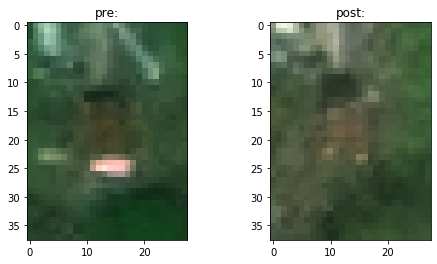

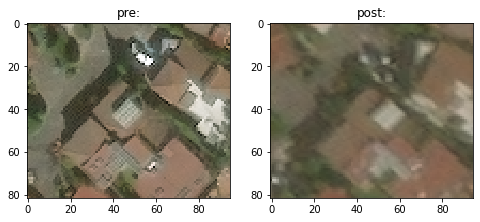

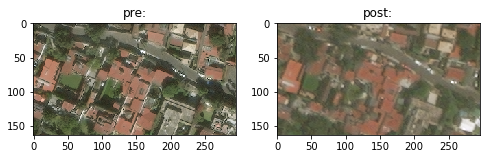

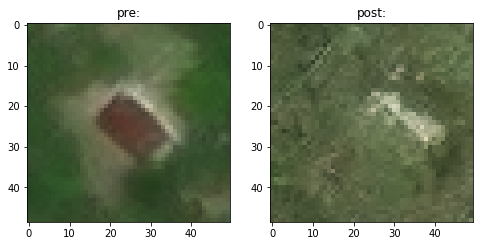

In [3]:
def plot_pre_post(image_fname, add_title=True):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axs = ax.ravel()
    pre_img = np.array(PIL.Image.open(image_crops_dir_pre/image_fname))
    post_img = np.array(PIL.Image.open(image_crops_dir_post/image_fname))
    axs[0].imshow(pre_img)
    axs[1].imshow(post_img)
    if add_title:
        axs[0].set_title(f'pre:')
        axs[1].set_title(f'post:')
_=[plot_pre_post(x.name) for x in image_crops_dir_post.ls()[:5]]

In [4]:
def get_train_valid_ids(classification_labels_df, img_id_col, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df[img_id_col].unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df[img_id_col].isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df[img_id_col].isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids

def is_valid_func(img_fname, valid_ids):
    id = Path(img_fname).name
    return id in valid_ids

In [5]:
train_pre_post = pd.read_csv(data_dir/"train_pre_post.csv")
train_pre_post['crop_filename']= train_pre_post.uuid.apply(lambda x: f"{x}.png")
train_pre_post.head()

train_ids, valid_ids = get_train_valid_ids(train_pre_post, "img_id_pre")
valid_func = partial(is_valid_func,valid_ids=valid_ids)
mean, std = torch.tensor(imagenet_stats)
mean.shape, std.shape, mean, std

(torch.Size([3]),
 torch.Size([3]),
 tensor([0.4850, 0.4560, 0.4060]),
 tensor([0.2290, 0.2240, 0.2250]))

In [6]:
def _resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`."
    for f in listify(tfms): f.resolve()
        
# class ImageTuple(Image):
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj= (img1,img2)
#         print(img1.data.max(), img2.data.max())
        #normalisation
        self.data = [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
#         self.data = [img1.data, img2.data]
    def apply_tfms(self, tfms, **kwargs):
        # using the do_resolve in this way here is important to make sure the same transform is applied to both images
        self.img1 = self.img1.apply_tfms(tfms, do_resolve=True, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, do_resolve=False, **kwargs)
        self.data = [self.img1.data,self.img2.data]
        return self

    
    def to_one(self): 
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])
    
class ImageTupleList(ImageList):
    _label_cls=CategoryList
    
    def __init__(self, items, path_pre=None, **kwargs):
        super().__init__(items, **kwargs)
        self.path_pre = path_pre
        self.copy_new.append('path_pre')
        
    def get(self, i):
        img1 = super().get(i)

        img2_filename = Path(self.path_pre)/Path(self.items[i]).name
        return ImageTuple(img1, open_image(img2_filename))
    
    def reconstruct(self, t:Tensor): 
#         return ImageTuple(Image(t[0]*std[...,None,None] +mean[...,None,None]),
#             Image(t[1]*std[...,None,None] +mean[...,None,None]))
        return ImageTuple(Image(t[0]),Image(t[1]))
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        
    @classmethod
    def from_df(cls, df, path_pre, path_post, **kwargs):
        res = super().from_df(df, path=path_post, path_pre=path_pre, **kwargs)
#         res.path = path_post
        return res


In [7]:
class TTSNet(nn.Module):
    def __init__(self, architecture=models.alexnet, 
                 lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False, n_classes=4):
        super(TTSNet, self).__init__()
        self.architecture= architecture
        self.emb_sz = emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.architecture, pretrained=True, 
            cut=learner.cnn_config(self.architecture)['cut'])
        self.head = learner.create_head(num_features_model(self.body) , self.emb_sz, 
                                        self.lin_ftrs, self.ps,self.bn_final)
        self.cnn1 = nn.Sequential(self.body, self.head)
        self.cnn2 = nn.Sequential(self.body, self.head)
        self.output = nn.Linear(num_features_model(self.cnn1), n_classes)

                                  
    def forward(self, x1, x2):
        output1 = self.cnn1(x1)
        output2 = self.cnn2(x2)
        dist = torch.abs(output1-output2)
    
        
        return self.output(dist)

In [12]:
partial_data_frac=0.2
size=128
bs=16

src = (ImageTupleList
       .from_df(train_pre_post, path_post=image_crops_dir_post, path_pre=image_crops_dir_pre, cols=['crop_filename'])
#        .use_partial_data(partial_data_frac)
       .split_by_valid_func(valid_func)
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(
            do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75
        ), size=size, tfm_y=False)
        .databunch(bs=bs))

In [13]:
def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
                             dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.long().unsqueeze(1), 1)
    
def multiclass_dice(input:Tensor, targs:Tensor, num_classes, eps:float=1e-8)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."

    targs = to_onehot(targs, num_classes=num_classes).squeeze()
    input = to_onehot(input.argmax(dim=1), num_classes=num_classes).squeeze()
#     print(input.shape, targs.shape)
    intersect = (input * targs).sum(dim=1).float()
#     print(intersect.shape)
    union = (input+targs).sum(dim=1).float()
#     print(intersect.shape(), union.shape(), intersect.sum(), union.sum())
    l = 2. * intersect / (union + eps)

    return l.mean()
def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#

In [14]:
class CombinedLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha)
#         bce_dice = BCEDiceLoss()
#         lovaz_loss = LovaszLossBinary()
#         dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = focal_loss(logit, target) #+ 0.2 * dice_loss(logit, y)
        return total_loss

In [15]:
dice_custom = partial(multiclass_dice, num_classes=4)
model = TTSNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
tts_learner = Learner(data, model,model_dir=models_path, metrics=[accuracy, f1])
tts_learner.loss_func =CombinedLoss(gamma=4., alpha=0.75);
tts_learner.to_fp16(); 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


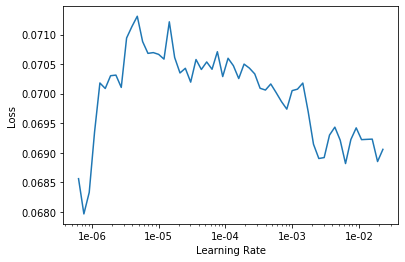

In [16]:
tts_learner.lr_find()
tts_learner.recorder.plot()

In [17]:
tts_learner.fit_one_cycle(3, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.063472,0.069075,0.767711,0.487247,49:47
1,0.060755,0.070631,0.767527,0.259178,02:27
2,0.059875,0.071999,0.707232,0.193489,02:27


In [18]:
tts_learner.fit_one_cycle(6, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.059873,0.071685,0.706496,0.222788,02:28
1,0.059367,0.071372,0.706925,0.241450,02:33
2,0.061543,0.071871,0.691897,0.222951,02:33
3,0.060338,0.072007,0.695516,0.211712,02:30
4,0.059106,0.071836,0.693860,0.227589,02:30
5,0.058568,0.071401,0.695209,0.249807,02:32


In [19]:
val_pred = tts_learner.get_preds(ds_type=DatasetType.Valid)

predictions, y, loss = tts_learner.get_preds(ds_type=DatasetType.Valid, with_loss=True)
pred_y = torch.argmax(predictions, dim=-1)

pd.Series(pred_y).value_counts(normalize=True)

0    0.889591
3    0.092008
2    0.016132
1    0.002270
dtype: float64

In [45]:
pd.Series(y.numpy()).value_counts(normalize=True)

0    0.764233
1    0.089418
2    0.073639
3    0.072710
dtype: float64

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


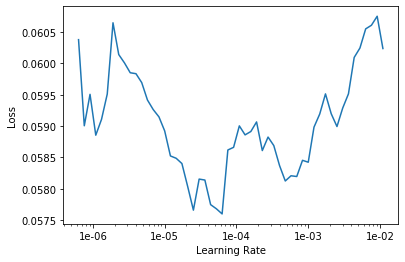

In [20]:
tts_learner.unfreeze()
tts_learner.lr_find()
tts_learner.recorder.plot()

In [21]:
tts_learner.fit_one_cycle(3, max_lr=1e-6)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.060326,0.071491,0.694903,0.242414,02:32
1,0.061083,0.071916,0.684782,0.235970,02:32
2,0.059293,0.072418,0.685395,0.196351,02:28


In [48]:
tts_learner.fit_one_cycle(10, max_lr=5e-7)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.973703,1.054529,0.730507,0.234578,00:23
1,1.002671,1.041891,0.733911,0.283574,00:23
2,0.998618,1.050209,0.729579,0.253965,00:24
3,0.983428,1.049272,0.735767,0.260075,00:23
4,0.987976,1.035643,0.731745,0.260865,00:23
5,1.078403,1.044550,0.737005,0.286433,00:23
6,1.068495,1.052826,0.737933,0.311980,00:24
7,0.981425,1.045746,0.732364,0.266265,00:24
8,1.045923,1.028335,0.739790,0.278807,00:24
9,1.056150,1.039121,0.737624,0.255361,00:24


In [22]:
val_pred = tts_learner.get_preds(ds_type=DatasetType.Valid)

predictions, y, loss = tts_learner.get_preds(ds_type=DatasetType.Valid, with_loss=True)
pred_y = torch.argmax(predictions, dim=-1)

pd.Series(pred_y).value_counts(normalize=True)

0    0.875054
3    0.098264
2    0.023922
1    0.002760
dtype: float64